<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

**1. Выберите наборы данных. которые можно интерпретировать, как временные ряды:**

а) зависимость цены на недвижимость в конкретном регионе от времени,

б) скорость полета самолета при перелете из аэропорта А в аэропорт В,

в) количество отказов компьютера,

г) число обращений в поликлинику по району,

д) координаты автобуса при движении по маршруту,

e) координаты фигуры нарушителя в файле видеофиксации охранной системы

**Solution**  
Комментарии:
- зависимость цены на недвижимость в конкретном регионе от времени: здесь явная связь с временным фактором
- скорость полета самолета по фиксированному маршруту можно представить как временной ряд, если задаться вопросом, как влияет время года на данную скорость. Однако здесь важным будет только сезонные колебания, т.к. автокорелляции по логике не должно быть
- количество отказов компьютера может потенциально содержать некоторую связь отказов в зависимости от отказов в прошлом
- число обращений в поликлинику по району можно рассматривать как временной ряд, т.к. это может показать определенные тренды и сезонности
- координаты автобуса при движении по маршруту: здесь явный временной ряд, т.к. текущая координата явно зависит от предыдущей.  
- координаты фигуры нарушителя в файле видеофиксации охранной системы - если стоит задача по восстановлению пропущенных данных (между фрагментами) - то задачу можно свести к временному ряду

Выводы:
Наилучшими с точки зрения интерпретации и полезности могут быть варианты А, Г и Д

**2. Прочитайте DUQ_hourly.csv и проверьте качество и порядок разметки этой выборки с информацией о потреблении энергии в одном из районов Восточной Электросети США. Сделайте описание особенностей этой выборки.**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
# 2.1. Data loading and NAN check
file_path = "../../P/DUQ_hourly.csv"
df = pd.read_csv(file_path, encoding='utf-8')
df = df.set_index('Datetime')
target = 'DUQ_MW'
display(df.isna().sum())
display(df.shape)
df[target] = df[target].astype(int)
df.index = pd.to_datetime(df.index)
display(df.info())
# как видно, пропусков не имеется

DUQ_MW    0
dtype: int64

(119068, 1)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 119068 entries, 2005-12-31 01:00:00 to 2018-01-02 00:00:00
Data columns (total 1 columns):
DUQ_MW    119068 non-null int32
dtypes: int32(1)
memory usage: 1.4 MB


None

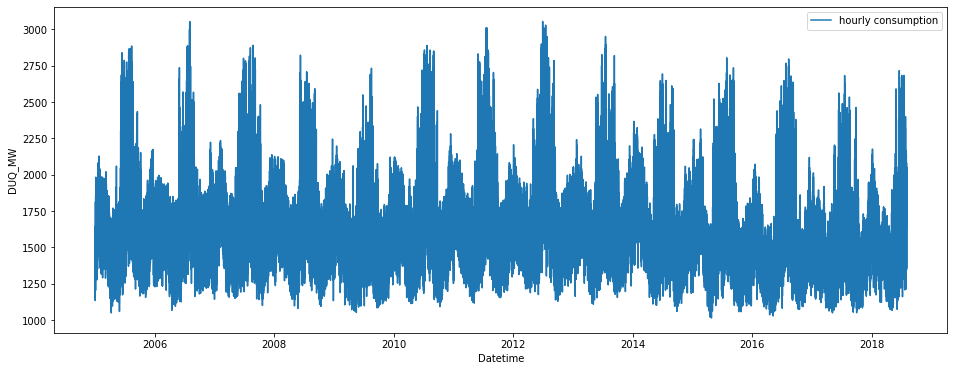

In [3]:
# 2.2. Visual analysis. First Step

fig, ax = plt.subplots(figsize=(16,6))
sns.lineplot(x=df.index, y=target, data=df, label = 'hourly consumption')

На графике видна некоторая сезонность и слабо выраженный отрицательный тренд

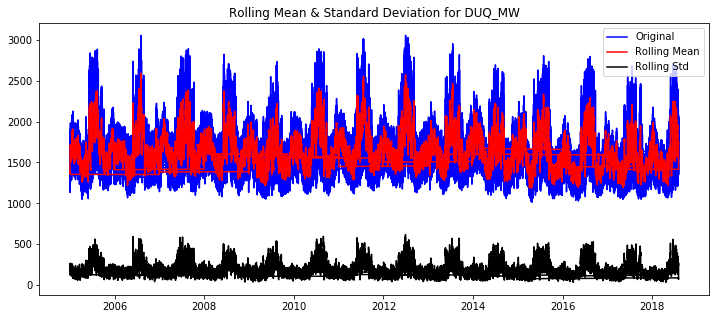

In [4]:
# посмотрим на график с вариацией и скользящей средней
def rolling_plots(df, col_name, window, figsize=(14,4)):
    ts = df[col_name]
    rolmean = ts.rolling(window = window, center = False).mean()
    rolstd = ts.rolling(window = window, center = False).std()
    fig = plt.figure(figsize=(12,5))
    orig = plt.plot(ts, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.title(f'Rolling Mean & Standard Deviation for {col_name}')
    plt.legend(loc='best')
    plt.show()

window = 24 # window = 1 day
rolling_plots(df, target, window)

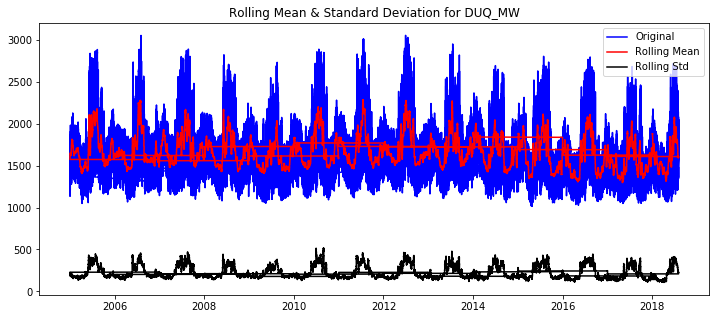

In [5]:
window = 168 # window = 1 week
rolling_plots(df, target, window)

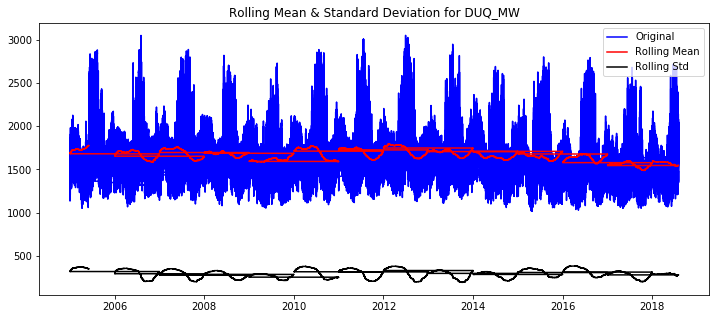

In [6]:
window = 5040 # window = 1 month
rolling_plots(df, target, window)

In [7]:
def add_period_cols(df):
    df_new = df.copy()
    df_new['month'] = df_new.index.month
    df_new['day_of_week'] = df_new.index.dayofweek
    df_new['day_of_month'] = df_new.index.day
    return df_new

df_enh = add_period_cols(df)
df_enh.head()

,DUQ_MW,month,day_of_week,day_of_month
Datetime,,,,
2005-12-31 01:00:00,1458,12,5,31
2005-12-31 02:00:00,1377,12,5,31
2005-12-31 03:00:00,1351,12,5,31
2005-12-31 04:00:00,1336,12,5,31
2005-12-31 05:00:00,1356,12,5,31


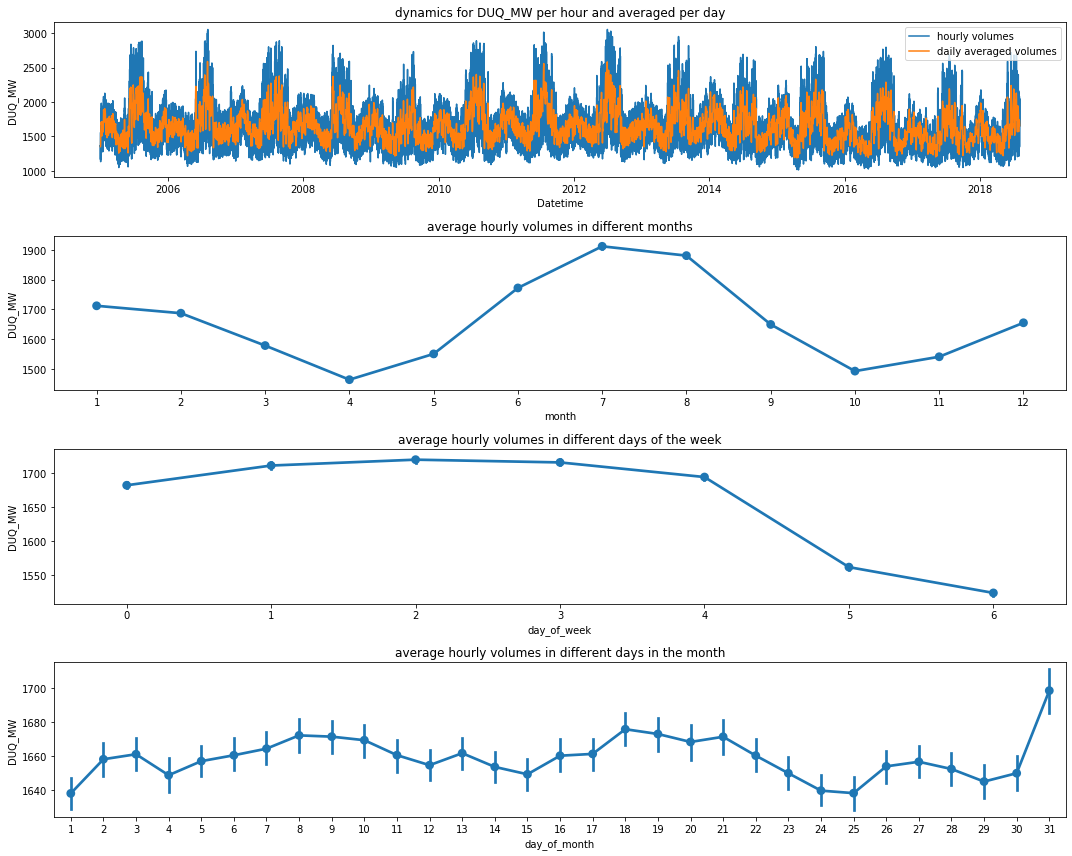

In [8]:
def eda_plots(df, target):
    fig, ax = plt.subplots(4,1, figsize = (15,12))
    ax[0].set_title(f'dynamics for {target} per hour and averaged per day')
    sns.lineplot(x=df.index, y=target, data=df, ax=ax[0], label='hourly volumes')
    df_pd = pd.DataFrame(df[target].resample('D').mean())
    sns.lineplot(x=df_pd.index, y=target, data=df_pd, ax=ax[0], label = 'daily averaged volumes')
    ax[0].legend(loc='best')
    ax[1].set_title('average hourly volumes in different months')
    ax[2].set_title('average hourly volumes in different days of the week')
    ax[3].set_title('average hourly volumes in different days in the month')
    sns.pointplot(data=df, x='month', y=target, ax=ax[1])
    sns.pointplot(data=df, x='day_of_week', y=target, ax=ax[2])
    sns.pointplot(data=df, x='day_of_month', y=target, ax=ax[3])
    plt.tight_layout()
    plt.show()
    
eda_plots(df_enh, target)

Особенность выборки:
- представлен временной ряд с данными за три года с почасовым периодом
- графический анализ показывает явную цикличность с длиной не более месяца
- также наблюдается цикличность и на уровне стандартного отклонения
- можно увидеть некоторую цикличность внутри дней в месяце, снижение в выходные дни, а также взаимосвязь с периодами года

**3. Прочитайте базу Brent и сделайте ее перерасчет (ресемплинг) в представление по неделям , по месяцам**

In [192]:
file_path = "../../P/нефть-brent 2010-2019.xlsx"
df = pd.read_excel(file_path, encoding='utf-8')
df = df.set_index('Дата')
target = 'Значение'
display(df.isna().sum())
df.index = pd.to_datetime(df.index)
display(df.info())
display(df.head())

Значение    0
dtype: int64

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2667 entries, 2019-09-01 to 2010-09-01
Data columns (total 1 columns):
Значение    2667 non-null float64
dtypes: float64(1)
memory usage: 41.7 KB


None

,Значение
Дата,
2019-09-01,58.84
2019-08-30,59.19
2019-08-29,60.37
2019-08-28,59.84
2019-08-27,59.59


In [164]:
# добавим переменные
ts = df[target]
rolmean = ts.rolling(window = 30, center = False).mean()
rolstd = ts.rolling(window = 30, center = False).std()
ts.shape, rolmean.shape

((2667,), (2667,))

In [226]:
def create_resampled_df(df, rule, name='', target='Значение', use_interpolate=True,
                        fill_nans_method='linear'):
    
    new_df = df.copy()
    new_df[name] = pd.DataFrame(df[target].resample(rule).mean())
    new_df[f'{name}_std'] = pd.DataFrame(df[target].resample(rule).std())
    new_df = new_df.drop(columns=[target], axis=1)
    if use_interpolate:
        new_df = new_df.interpolate(method=fill_nans_method)
    return new_df

df_pw = create_resampled_df(df, 'W', name='weekly', use_interpolate=True)
df_pm = create_resampled_df(df, 'M', name='monthly', use_interpolate=True)
df_pa = create_resampled_df(df, 'A', name='annually', use_interpolate=True)

In [228]:
display(df_pw.head())
df_pw.shape

,weekly,weekly_std
Дата,,
2019-09-01,59.348333,0.749918
2019-08-30,59.372778,0.784906
2019-08-29,59.397222,0.819895
2019-08-28,59.421667,0.854883
2019-08-27,59.446111,0.889872


(2667, 2)

In [229]:
display(df_pm.head())
df_pm.shape

,monthly,monthly_std
Дата,,
2019-09-01,NaN,NaN
2019-08-30,NaN,NaN
2019-08-29,NaN,NaN
2019-08-28,NaN,NaN
2019-08-27,NaN,NaN


(2667, 2)

In [230]:
display(df_pa.head())
df_pa.shape

,annually,annually_std
Дата,,
2019-09-01,NaN,NaN
2019-08-30,NaN,NaN
2019-08-29,NaN,NaN
2019-08-28,NaN,NaN
2019-08-27,NaN,NaN


(2667, 2)

**4. Постройте график изменения среднего по выборке и среднего отклонения по выборке на недельных, месячных и годовых группах для Brent.**

In [231]:
columns=['daily', 'weekly', 'weekly_std','monthly', 'monthly_std', 'annually', 'annualy_std']
# объединим все объекты
df_all = pd.concat(objs=[df, df_pw, df_pm, df_pa], axis=1, names=columns)

df_all = df_all.rename(columns={'Значение':'daily'})
#df_all = df_all.sort_index()
df_all

,daily,weekly,weekly_std,monthly,monthly_std,annually,annually_std
Дата,,,,,,,
2019-09-01,58.84,59.348333,0.749918,NaN,NaN,NaN,NaN
2019-08-30,59.19,59.372778,0.784906,NaN,NaN,NaN,NaN
2019-08-29,60.37,59.397222,0.819895,NaN,NaN,NaN,NaN
2019-08-28,59.84,59.421667,0.854883,NaN,NaN,NaN,NaN
2019-08-27,59.59,59.446111,0.889872,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2010-09-05,76.63,76.616000,0.185688,78.228148,1.294269,84.963238,5.269065
2010-09-04,76.62,76.616000,0.185688,78.228148,1.294269,84.963238,5.269065
2010-09-03,76.57,76.616000,0.185688,78.228148,1.294269,84.963238,5.269065


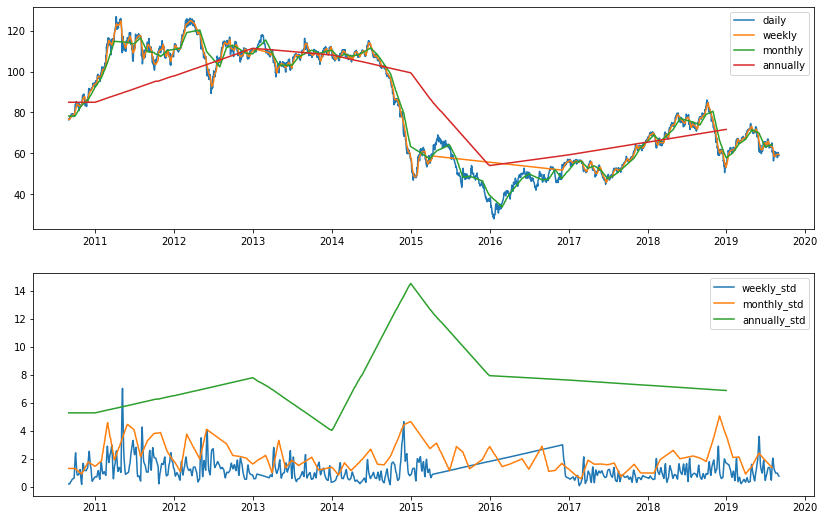

In [232]:
fig, ax = plt.subplots(2,1, figsize=(14,9))
mean_cols = ['daily', 'weekly', 'monthly', 'annually']
std_cols = ['weekly_std', 'monthly_std', 'annually_std']
for col in mean_cols:
    ax[0].plot(df_all[col], label=col)
    ax[0].legend()
for col in std_cols:
    ax[1].plot(df_all[col], label=col)
    ax[1].legend()

plt.show()

**5. Сделайте вывод о том, как изменилось поведение цены на недельных и месячных графиках по сравнению с дневными.**

Выводы из графика
- общие тренды и цикличность сохраняются при увеличении окна сглаживания, при этому уменьшается шум
- на месячном графике можно увидеть некоторую квартальную цикличность
- дисперсия для обоих графиков ведет себя достаточно стабильно

Как видно из графиков выше, усредненные еженедельные и ежемесячные котировки БРЕНТ достаточно хорошо отражают общие характеристики показателя, о чем в том числе свидетельствует стабильный (близкий к постоянной) график стандартного отклонения. Возможно это связано с тем, что существенную долю в ценообразование БРЕНТ вносят фьючерсные и форвардные контракты, сглаживающие ежедневную волотильность на определенный день.